In [313]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

Read Classifiers for Face and Eyes

In [314]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("haarcascade_eye.xml")

Import Image Files

In [315]:
img_01 = cv2.imread("img/train_01.jpg")
img_02 = cv2.imread("img/train_02.jpg")
img_03 = cv2.imread("img/train_03.jpg")
img_04 = cv2.imread("img/train_04.jpg")
img_05 = cv2.imread("img/train_05.jpg")
img_06 = cv2.imread("img/train_06.jpg")
img_07 = cv2.imread("img/train_07.jpg")
img_08 = cv2.imread("img/train_08.jpg")
img_09 = cv2.imread("img/train_09.jpg")
img_10 = cv2.imread("img/train_10.jpg")

Define a function to changecolor space type

In [316]:
def change_color(pic_list):
    new_list = []
    for img in pic_list:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_list.append(img)

    return new_list

Add Images to List for Looping

In [317]:
img_list = [img_01, img_02, img_03, img_04, img_05, img_06, img_07, img_08, img_09, img_10] 

Convert each img from BGR to RGB

In [318]:
img_list = change_color(img_list)

Verify all pics were output after conversion

In [319]:
print(len(img_list))

10


# Part 1

Create a dictionary to save coordinates and a list to save clicks

In [320]:
eye_coords = {}
clicks = []

Define a function to fit image in screen

In [321]:
original_scale = 1

def resize_image(image, width):
    original_height, original_width = image.shape[:2]
    aspect_ratio = original_width / original_height
    height = int(width / aspect_ratio)
    resize_scale = original_width / width 
    resized_image = cv2.resize(image, (width, height))
    return resized_image

Define a function to manage coordinates of image clicks

In [322]:
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        original_x = int(x * original_scale)
        original_y = int(y * original_scale)
        print(f"Clicked at: ({x}, {y})")
        clicks.append(original_x )
        clicks.append(original_y)
        cv2.circle(param, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Image", param)

Run the click events for each image, click eye centers, save coordinates

In [323]:
count = 0

for i in range(len(img_list)):
    resized_img = resize_image(img_list[count], 800)
    cv2.imshow("Image", resized_img)
    cv2.setMouseCallback("Image", click_event, resized_img)
    eye_coords[i] = clicks
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    clicks = []
    count += 1

Clicked at: (311, 307)
Clicked at: (465, 303)
Clicked at: (428, 400)
Clicked at: (571, 403)
Clicked at: (198, 345)
Clicked at: (338, 294)
Clicked at: (265, 503)
Clicked at: (564, 499)
Clicked at: (262, 471)
Clicked at: (520, 476)
Clicked at: (268, 398)
Clicked at: (470, 396)
Clicked at: (431, 288)
Clicked at: (546, 334)
Clicked at: (383, 379)
Clicked at: (544, 379)
Clicked at: (316, 351)
Clicked at: (492, 351)
Clicked at: (293, 285)
Clicked at: (506, 299)


Verify coordinates saved in the dictionary

In [324]:
print(eye_coords)

{0: [311, 307, 465, 303], 1: [428, 400, 571, 403], 2: [198, 345, 338, 294], 3: [265, 503, 564, 499], 4: [262, 471, 520, 476], 5: [268, 398, 470, 396], 6: [431, 288, 546, 334], 7: [383, 379, 544, 379], 8: [316, 351, 492, 351], 9: [293, 285, 506, 299]}


# Part 2

Create a function that measures the distance between the eye coordinates and returns the difference compared to true center

In [325]:
def measure_distance(LX, LY, GLX, GLY, RX, RY, GRX, GRY):
    
    def euc_distance(x1, y1, x2, y2):
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    
    if LX is None and LY is None:
        left_eye = 10.0
    else:
        left_eye = euc_distance(LX, LY, GLX, GLY)

    if RX is None and RY is None:
        right_eye = 10.0
    else:
        right_eye = euc_distance(RX, RY, GRX, GRY)
    
    distance = abs(left_eye - right_eye)

    return distance

# Part 3

Create a function that runs eye detection 1000 times, incrementing the scale factor from 0.01 to 2.00 by 0.01 inside incrementing min neighbors from 1 to 10 by 1. Save locations and compare each to true center. Save and return results.

In [326]:
def detect_eyes(img, g_distances):
    min_neighbors = 1
    scale_factor = 1.01
    total_count = 0
    eye_distances = []
    coordinate_distances = [[],[],[],[],[],[],[],[],[],[]]

    while min_neighbors <= 10:
        while scale_factor <= 2.01:
            eye_img = img.copy()
            height, width, channels = eye_img.shape
            eye_rect = eye_cascade.detectMultiScale(
                eye_img, 
                scaleFactor = scale_factor, 
                minNeighbors = min_neighbors,
                minSize = (int(width * 0.15), int(height * 0.15))
                )

            for (x, y, w, h) in eye_rect:
                if (y + h / 2 > height * 0.5):
                     continue
                
                if len(eye_distances) < 4:
                    eye_distances.append(x)
                    eye_distances.append(y)
                    # Blue Box
                    cv2.rectangle(eye_img, (x, y), (x + w, y + h), (255, 0, 0), 1)

            if len(eye_distances) < 2:
                eye_distances.append(None)
                eye_distances.append(None)
                eye_distances.append(None)
                eye_distances.append(None)

            if len(eye_distances) < 4:
                eye_distances.append(None)
                eye_distances.append(None)

            glx, gly, grx, gry = g_distances             
            lx, ly, rx, ry = eye_distances 
            measured = measure_distance(lx, ly, glx, gly, rx, ry, grx, gry)
            py_measured = float(measured)
            round_measured = round(py_measured, 2)
            coordinate_distances[min_neighbors - 1].append(round_measured)
                
            total_count += 1
            scale_factor += 0.01
            eye_distances = []
        
        scale_factor = 1.01
        min_neighbors += 1


    return coordinate_distances, total_count

Run eye detection on all 10 images (10000 times total). Save the differences of each.

In [327]:
eye_images_copy = img_list.copy()
box_coords = []
boxes = []
overall_total = 0

for i in range(len(img_list)):
    boxes, total = detect_eyes(eye_images_copy[i], eye_coords[i])
    box_coords.append(boxes)
    overall_total += total

Verify tests were run correct number of times

In [328]:
print(overall_total)
print(len(box_coords))
print(len(box_coords[0]))
print(len(box_coords[0][0]))

10000
10
10
100


# Part 4

Create a csv file of the accumulated data

In [329]:
scale_factors = [round(x, 2) for x in np.arange(1.01, 2.01, 0.01)]
min_neighbors = list(range(1, 11))

for idx, table in enumerate(box_coords):
    df = pd.DataFrame(table)
    df.index = min_neighbors
    df.columns = scale_factors
    df.index.name = 'min_neighbors'
    df.columns.name = 'scale_factor'

    df.to_csv(f'eye_table_{idx}.csv')

Creat a function to add data to a table

In [330]:
def plot_tab(table_num):
    df = pd.read_csv(f"eye_table_{table_num}.csv", index_col = 0)
    df.columns.name = "scale_factor"
    styled_df = df.style.set_table_styles([
        {'selector': 'th, td', 'props': [('border', '1px solid black')]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse')]}        
    ])

    display(styled_df)

Call the function to output data table for each image

In [331]:
for i in range(10):
    plot_tab(i)

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,143.360000,142.700000,90.980000,144.110000,92.530000,91.140000,90.280000,92.370000,142.610000,88.910000,142.840000,89.730000,91.820000,88.740000,141.060000,93.390000,90.580000,92.680000,144.730000,143.740000,144.250000,93.080000,87.510000,89.730000,92.070000,90.930000,89.580000,93.330000,99.190000,356.310000,90.110000,89.260000,93.450000,90.310000,142.810000,91.720000,90.040000,141.740000,94.700000,91.180000,143.630000,91.460000,92.280000,122.210000,91.730000,143.400000,102.380000,89.610000,143.160000,143.830000,86.820000,142.220000,91.130000,91.130000,91.840000,93.480000,89.880000,90.740000,91.670000,89.020000,90.020000,88.190000,91.630000,353.460000,93.080000,352.050000,87.790000,87.190000,356.310000,91.220000,354.170000,330.820000,330.820000,89.260000,88.440000,90.520000,140.990000,0.000000,90.380000,90.380000,332.150000,0.000000,353.450000,90.110000,89.080000,331.580000,0.000000,330.820000,89.660000,335.720000,0.000000,0.000000,0.000000,0.000000,356.310000,0.000000,0.000000,0.000000,334.400000,143.830000
2,143.360000,142.700000,90.980000,144.110000,92.530000,91.140000,90.280000,92.370000,142.610000,88.910000,142.840000,89.730000,91.820000,88.740000,141.060000,93.390000,90.580000,92.680000,144.730000,143.740000,144.250000,93.080000,87.510000,353.460000,354.180000,90.930000,89.580000,93.330000,352.050000,0.000000,331.580000,355.590000,93.450000,90.310000,142.810000,91.720000,90.040000,141.740000,94.700000,91.180000,143.630000,91.460000,350.640000,327.910000,91.730000,143.400000,351.350000,89.610000,143.160000,143.830000,86.820000,142.220000,352.060000,352.060000,142.740000,352.760000,89.880000,90.740000,91.670000,328.660000,328.100000,88.190000,330.820000,353.460000,93.080000,352.050000,353.460000,354.890000,0.000000,91.220000,354.170000,330.820000,330.820000,355.590000,355.580000,90.520000,330.070000,0.000000,90.380000,90.380000,332.150000,0.000000,353.450000,355.580000,332.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.400000,335.810000
3,143.360000,142.700000,90.980000,144.110000,92.530000,91.140000,90.280000,92.370000,142.610000,88.910000,142.840000,89.730000,91.820000,88.740000,141.060000,93.390000,90.580000,92.680000,144.730000,330.070000,352.060000,93.080000,87.510000,353.460000,354.180000,143.280000,89.580000,353.460000,352.050000,0.000000,0.000000,0.000000,326.500000,90.310000,142.810000,91.720000,90.040000,141.740000,94.700000,327.250000,327.250000,350.640000,0.000000,327.910000,350.650000,351.350000,351.350000,352.750000,143.160000,143.830000,86.820000,0.000000,352.060000,352.060000,328.660000,0.000000,0.000000,0.000000,142.470000,328.660000,328.100000,88.190000,330.820000,353.460000,93.080000,352.050000,353.460000,354.890000,0.000000,331.670000,354.170000,330.820000,330.820000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,355.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,143.360000,142.700000,90.980000,144.110000,92.530000,91.140000,90.280000,92.370000,142.610000,88.910000,142.840000,89.730000,91.820000,354.180000,141.060000,93.390000,90.580000,92.680000,144.730000,330.070000,352.060000,93.080000,87.510000,353.460000,354.180000,143.280000,329.410000,353.460000,0.000000,0.000000,

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,245.990000,418.620000,0.000000,1197.460000,0.000000,0.000000,1184.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1216.960000,0.000000,1190.590000,0.000000,0.000000,0.000000,0.000000,0.000000,1181.450000,1186.110000,0.000000,0.000000,0.000000,1130.850000,1156.490000,0.000000,0.000000,1157.460000,1166.760000,0.000000,0.000000,1107.380000,0.000000,1156.760000,0.000000,0.000000,1200.220000,0.000000,1153.830000,1098.160000,0.000000,0.000000,0.000000,0.000000,0.000000,1099.730000,0.000000,0.000000,1207.290000,1171.020000,0.000000,0.000000,1096.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1147.540000,0.000000,0.000000,1095.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1130.190000,0.000000,0.000000,1154.460000,1096.150000,1095.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1189.600000,0.000000,1127.370000,1166.010000,0.000000,0.000000
2,245.990000,0.000000,0.000000,1197.460000,0.000000,0.000000,1184.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1216.960000,0.000000,1190.590000,0.000000,0.000000,0.000000,0.000000,0.000000,1181.450000,1186.110000,0.000000,0.000000,0.000000,0.000000,1156.490000,0.000000,0.000000,1157.460000,1166.760000,0.000000,0.000000,1107.380000,0.000000,1156.760000,0.000000,0.000000,1200.220000,0.000000,1153.830000,1098.160000,0.000000,0.000000,0.000000,0.000000,0.000000,1099.730000,0.000000,0.000000,1207.290000,1171.020000,0.000000,0.000000,1096.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1147.540000,0.000000,0.000000,1095.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1096.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1166.010000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1197.460000,0.000000,0.000000,1184.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1216.960000,0.000000,1190.590000,0.000000,0.000000,0.000000,0.000000,0.000000,1181.450000,1186.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1157.460000,1166.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1200.220000,0.000000,1153.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1099.730000,0.000000,0.000000,1207.290000,1171.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1096.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1166.010000,0.000000,0.000000
4,0.000000,0.000000,0.000000,1197.460000,0.000000,0.000000,1184.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1216.960000,0.000000,1190.590000,0.000000,0.000000,0.000000,0.000000,0.000000,1181.450000,1186.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1166.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1200.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1099.730000,0.000000,0.0000

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,82.210000,82.250000,84.950000,80.760000,91.080000,86.760000,91.070000,83.880000,84.480000,85.430000,13.210000,182.310000,0.000000,99.790000,72.540000,0.000000,172.270000,171.010000,83.800000,0.000000,163.180000,78.660000,85.220000,184.000000,165.140000,161.600000,0.000000,0.000000,80.820000,164.290000,161.600000,174.170000,0.000000,0.000000,0.000000,161.420000,164.290000,173.040000,0.000000,87.400000,185.000000,171.180000,0.000000,0.000000,0.000000,87.150000,81.690000,167.050000,82.340000,169.180000,171.020000,0.000000,182.310000,0.000000,171.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163.180000,161.420000,94.160000,164.290000,82.620000,173.040000,168.230000,0.000000,86.290000,0.000000,0.000000,0.000000,0.000000,171.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,82.210000,82.250000,84.950000,80.760000,91.080000,86.760000,167.100000,83.880000,84.480000,85.430000,169.010000,0.000000,0.000000,99.790000,167.630000,0.000000,172.270000,0.000000,0.000000,0.000000,0.000000,78.660000,0.000000,0.000000,165.140000,0.000000,0.000000,0.000000,157.740000,164.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,164.290000,0.000000,0.000000,170.040000,0.000000,0.000000,0.000000,0.000000,0.000000,160.580000,0.000000,0.000000,163.600000,169.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,164.000000,164.290000,165.000000,0.000000,168.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,82.210000,82.250000,84.950000,80.760000,91.080000,86.760000,167.100000,83.880000,84.480000,85.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,165.000000,0.000000,0.000000,165.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,160.580000,0.000000,0.000000,163.600000,169.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,165.000000,0.000000,168.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,82.210000,82.250000,84.950000,80.760000,91.080000,86.760000,167.100000,0.000000,174.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,165.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163.600000,169.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,702.450000,705.920000,419.340000,708.610000,703.730000,685.040000,702.040000,689.850000,431.400000,455.820000,707.220000,714.380000,714.610000,428.200000,710.520000,708.960000,671.190000,689.050000,726.150000,699.540000,728.170000,739.290000,688.060000,443.160000,409.290000,696.460000,458.930000,690.980000,696.170000,465.830000,421.520000,1582.440000,420.450000,356.440000,679.040000,831.510000,472.860000,463.870000,786.560000,270.160000,744.990000,484.950000,473.830000,760.150000,752.590000,525.290000,764.680000,461.060000,494.950000,418.300000,204.240000,470.200000,472.130000,530.560000,484.780000,462.210000,937.100000,489.430000,433.250000,748.110000,470.190000,461.230000,494.330000,472.860000,484.330000,471.090000,495.200000,460.490000,1545.390000,457.880000,508.060000,452.010000,767.990000,770.660000,758.620000,650.450000,498.630000,1092.190000,730.440000,459.820000,1590.170000,457.080000,456.920000,478.480000,501.730000,711.130000,507.100000,446.370000,386.960000,348.550000,360.550000,387.140000,766.830000,738.200000,764.910000,744.890000,740.390000,701.270000,476.030000,763.040000
2,702.450000,705.920000,419.340000,708.610000,703.730000,685.040000,702.040000,689.850000,431.400000,455.820000,707.220000,714.380000,714.610000,428.200000,710.520000,708.960000,671.190000,689.050000,726.150000,699.540000,728.170000,739.290000,688.060000,443.160000,409.290000,696.460000,458.930000,690.980000,696.170000,465.830000,421.520000,1582.440000,420.450000,356.440000,679.040000,831.510000,472.860000,463.870000,786.560000,270.160000,744.990000,484.950000,473.830000,760.150000,752.590000,525.290000,764.680000,461.060000,494.950000,418.300000,204.240000,470.200000,472.130000,530.560000,484.780000,462.210000,937.100000,489.430000,433.250000,748.110000,470.190000,461.230000,494.330000,472.860000,484.330000,471.090000,495.200000,460.490000,1545.390000,457.880000,508.060000,452.010000,767.990000,770.660000,758.620000,650.450000,498.630000,1656.320000,730.440000,459.820000,1590.170000,457.080000,456.920000,478.480000,501.730000,711.130000,507.100000,446.370000,386.960000,348.550000,360.550000,387.140000,766.830000,738.200000,764.910000,744.890000,740.390000,1651.930000,476.030000,763.040000
3,702.450000,705.920000,419.340000,708.610000,703.730000,685.040000,702.040000,689.850000,431.400000,455.820000,707.220000,714.380000,714.610000,428.200000,710.520000,708.960000,671.190000,689.050000,726.150000,699.540000,728.170000,739.290000,688.060000,443.160000,409.290000,696.460000,458.930000,690.980000,696.170000,465.830000,421.520000,1582.440000,420.450000,356.440000,679.040000,831.510000,472.860000,463.870000,786.560000,270.160000,744.990000,484.950000,473.830000,760.150000,752.590000,525.290000,764.680000,461.060000,494.950000,418.300000,204.240000,470.200000,472.130000,530.560000,484.780000,462.210000,1584.600000,489.430000,433.250000,748.110000,470.190000,461.230000,494.330000,472.860000,484.330000,471.090000,495.200000,460.490000,1545.390000,457.880000,508.060000,452.010000,767.990000,770.660000,758.620000,650.450000,498.630000,1656.320000,730.440000,459.820000,1590.170000,457.080000,456.920000,478.480000,501.730000,711.130000,507.100000,446.370000,386.960000,348.550000,360.550000,1318.710000,766.830000,738.200000,764.910000,744.890000,740.390000,1651.930000,476.030000,763.040000
4,702.450000,705.920000,419.340000,708.610000,703.730000,685.

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,211.760000,210.940000,64.610000,208.710000,300.380000,2.990000,218.030000,215.000000,33.750000,7.710000,203.050000,1.960000,38.290000,2.110000,2.730000,233.700000,38.940000,204.710000,15.360000,220.150000,213.510000,31.660000,170.620000,197.520000,184.610000,182.770000,184.740000,5.780000,159.430000,231.430000,82.640000,142.840000,192.470000,216.380000,38.990000,0.000000,19.180000,161.860000,157.030000,15.630000,4.960000,0.000000,27.410000,157.360000,0.000000,1.410000,198.970000,23.960000,0.000000,104.310000,196.690000,172.430000,157.360000,177.490000,184.740000,183.100000,13.810000,0.000000,178.450000,27.010000,141.350000,149.910000,24.130000,196.690000,27.410000,163.510000,191.640000,0.000000,186.900000,2.100000,183.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,209.320000,130.730000,29.190000,166.500000,0.000000,28.560000,174.460000,5.100000,131.680000,27.410000,177.020000,159.430000,192.470000,33.050000,0.000000,184.740000,0.000000,181.000000,190.470000,0.000000,0.000000,0.000000,0.000000
2,211.760000,210.940000,64.610000,208.710000,300.380000,2.990000,218.030000,215.000000,33.750000,7.710000,203.050000,1.960000,38.290000,2.110000,2.730000,233.700000,38.940000,204.710000,15.360000,220.150000,197.410000,201.630000,170.620000,144.250000,184.610000,182.770000,0.000000,175.610000,159.430000,176.210000,23.690000,0.000000,0.000000,216.380000,38.990000,0.000000,169.180000,161.860000,157.030000,15.630000,4.960000,0.000000,159.620000,157.360000,0.000000,1.410000,198.970000,144.210000,0.000000,139.930000,196.690000,172.430000,157.360000,177.490000,0.000000,0.000000,212.140000,0.000000,178.450000,163.230000,141.350000,0.000000,174.760000,196.690000,159.620000,163.510000,0.000000,0.000000,0.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,209.320000,0.000000,163.230000,166.500000,0.000000,28.560000,174.460000,174.720000,0.000000,159.620000,0.000000,159.430000,0.000000,201.810000,0.000000,0.000000,0.000000,0.000000,190.470000,0.000000,0.000000,0.000000,0.000000
3,211.760000,210.940000,17.500000,208.710000,211.140000,2.990000,218.030000,215.000000,33.750000,7.710000,203.050000,1.960000,38.290000,2.110000,2.730000,233.700000,38.940000,204.710000,174.490000,151.070000,197.410000,0.000000,170.620000,144.250000,0.000000,182.770000,0.000000,175.610000,159.430000,176.210000,23.690000,0.000000,0.000000,157.030000,38.990000,0.000000,169.180000,161.860000,157.030000,15.630000,4.960000,0.000000,159.620000,157.360000,0.000000,173.530000,189.060000,144.210000,0.000000,139.930000,0.000000,172.430000,157.360000,177.490000,0.000000,0.000000,0.000000,0.000000,178.450000,0.000000,141.350000,0.000000,0.000000,0.000000,159.620000,163.510000,0.000000,0.000000,0.000000,173.740000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,174.720000,0.000000,159.620000,0.000000,159.430000,0.000000,0.000000,0.000000,0.000000,173.530000,0.000000,190.470000,0.000000,0.000000,0.000000,0.000000
4,211.760000,210.940000,17.500000,208.710000,211.140000,2.990000,218.030000,215.000000,33.750000,154.760000,203.050000,1.960000,38.290000,2.110000,2.730000,233.700000,38.940000,204.710000,0.000000,151.070000,0.000000,0.000000,170.620000,144.250000,0.000000,182.770000,0.000000,175.610000,0.000000,0.000000,168.280000,0.000000,0.000000,0.000000,154.200000,0.00

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,10.300000,11.710000,10.210000,13.010000,11.630000,6.060000,11.120000,11.600000,8.060000,6.740000,5.350000,7.430000,13.730000,13.040000,8.050000,5.750000,21.170000,12.600000,9.050000,6.140000,13.820000,6.830000,13.300000,18.740000,13.280000,12.880000,25.040000,9.170000,5.250000,15.710000,190.950000,2.400000,14.010000,4.890000,11.570000,16.570000,17.270000,203.640000,10.020000,13.100000,13.600000,11.980000,13.190000,196.760000,14.990000,14.020000,155.410000,154.220000,7.740000,12.280000,14.350000,8.480000,15.440000,15.930000,197.200000,197.880000,204.580000,191.460000,204.280000,154.000000,0.000000,0.000000,0.000000,10.030000,2.720000,12.280000,13.530000,5.340000,11.540000,11.270000,13.190000,12.880000,197.700000,2.350000,185.990000,186.940000,191.770000,155.700000,0.000000,154.000000,200.240000,142.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.710000,9.150000,3.390000,13.100000,9.340000,14.940000,12.920000,9.360000
2,10.300000,11.710000,10.210000,13.010000,11.630000,6.060000,11.120000,11.600000,8.060000,6.740000,5.350000,7.430000,13.730000,13.040000,8.050000,5.750000,21.170000,12.600000,9.050000,6.140000,13.820000,6.830000,13.300000,18.740000,13.280000,12.880000,25.040000,9.170000,5.250000,15.710000,190.950000,2.400000,14.010000,4.890000,11.570000,16.570000,17.270000,203.640000,10.020000,13.100000,13.600000,11.980000,13.190000,196.760000,14.990000,14.020000,155.410000,154.220000,7.740000,12.280000,14.350000,8.480000,15.440000,15.930000,197.200000,197.880000,204.580000,191.460000,204.280000,154.000000,0.000000,0.000000,0.000000,10.030000,2.720000,12.280000,13.530000,5.340000,11.540000,11.270000,13.190000,12.880000,197.700000,2.350000,185.990000,152.930000,191.770000,155.700000,0.000000,154.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.710000,9.150000,3.390000,13.100000,9.340000,14.940000,12.920000,9.360000
3,10.300000,11.710000,10.210000,13.010000,11.630000,6.060000,11.120000,11.600000,8.060000,6.740000,5.350000,7.430000,13.730000,13.040000,8.050000,5.750000,21.170000,12.600000,9.050000,6.140000,13.820000,6.830000,13.300000,18.740000,13.280000,12.880000,25.040000,9.170000,5.250000,15.710000,190.950000,2.400000,14.010000,4.890000,11.570000,16.570000,17.270000,142.860000,10.020000,13.100000,13.600000,11.980000,13.190000,196.760000,14.990000,14.020000,0.000000,0.000000,7.740000,12.280000,14.350000,8.480000,15.440000,15.930000,197.200000,197.880000,141.920000,191.460000,152.930000,0.000000,0.000000,0.000000,0.000000,10.030000,2.720000,12.280000,13.530000,5.340000,11.540000,11.270000,13.190000,12.880000,197.700000,2.350000,185.990000,152.930000,191.770000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.710000,9.150000,3.390000,13.100000,9.340000,14.940000,12.920000,9.360000
4,10.300000,11.710000,10.210000,13.010000,11.630000,6.060000,11.120000,11.600000,8.060000,6.740000,5.350000,7.430000,13.730000,13.040000,8.050000,5.750000,21.170000,12.600000,9.050000,6.140000,13.820000,6.830000,13.300000,18.740000,13.280000,12.880000,25.040000,9.170000,5.250000,15.710000,190.950000,177.880000,14.010000,4.890000,11.570000,16.570000,17.270000,142.860000,10.020000,13.100000,13.600000,11.980000,13.190000,196.760000,14.990000,14.020

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20.270000,19.240000,18.670000,18.650000,23.080000,20.840000,15.840000,24.470000,20.880000,18.100000,22.300000,22.260000,26.480000,25.080000,25.300000,13.410000,23.890000,13.620000,226.810000,16.880000,13.660000,19.490000,22.270000,19.260000,228.000000,228.210000,18.120000,18.230000,17.000000,8.990000,230.410000,232.620000,28.000000,30.460000,29.470000,140.670000,14.570000,150.930000,224.800000,223.030000,228.210000,28.930000,24.300000,139.070000,18.020000,25.000000,154.140000,219.400000,26.070000,226.810000,224.200000,219.610000,235.420000,230.670000,234.100000,237.420000,239.260000,0.000000,0.000000,32.430000,28.470000,26.480000,31.040000,22.040000,24.490000,19.860000,219.800000,224.930000,13.770000,25.490000,221.630000,9.460000,230.000000,228.810000,218.810000,0.000000,232.610000,229.890000,238.650000,230.800000,15.800000,235.670000,242.620000,0.000000,239.400000,0.000000,0.000000,0.000000,0.000000,254.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,20.270000,19.240000,18.670000,18.650000,23.080000,20.840000,15.840000,24.470000,20.880000,18.100000,22.300000,22.260000,26.480000,25.080000,25.300000,13.410000,23.890000,13.620000,226.810000,16.880000,13.660000,19.490000,22.270000,19.260000,228.000000,228.210000,18.120000,18.230000,17.000000,228.210000,230.410000,232.620000,28.000000,30.460000,29.470000,219.800000,223.430000,150.930000,224.800000,223.030000,228.210000,28.930000,24.300000,24.870000,18.020000,25.000000,154.140000,219.400000,26.070000,226.810000,224.200000,0.000000,235.420000,230.670000,0.000000,237.420000,239.260000,0.000000,0.000000,32.430000,28.470000,26.480000,31.040000,22.040000,24.490000,19.860000,219.800000,224.930000,223.430000,25.490000,221.630000,232.610000,230.000000,228.810000,0.000000,0.000000,232.610000,229.890000,0.000000,230.800000,15.800000,0.000000,242.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,254.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,20.270000,19.240000,18.670000,18.650000,23.080000,20.840000,15.840000,24.470000,20.880000,18.100000,22.300000,22.260000,26.480000,25.080000,25.300000,13.410000,23.890000,13.620000,226.810000,16.880000,13.660000,228.000000,22.270000,19.260000,228.000000,228.210000,18.120000,18.230000,17.000000,228.210000,230.410000,232.620000,28.000000,30.460000,29.470000,219.800000,223.430000,221.630000,224.800000,0.000000,0.000000,28.930000,24.300000,24.870000,18.020000,25.000000,219.800000,219.400000,220.600000,226.810000,224.200000,0.000000,235.420000,230.670000,0.000000,237.420000,0.000000,0.000000,0.000000,32.430000,28.470000,26.480000,31.040000,22.040000,24.490000,19.860000,219.800000,229.620000,223.430000,222.000000,221.630000,232.610000,230.000000,228.810000,0.000000,0.000000,0.000000,229.890000,0.000000,230.800000,15.800000,0.000000,242.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,20.270000,19.240000,18.670000,18.650000,23.080000,20.840000,15.840000,24.470000,20.880000,18.100000,22.300000,22.260000,26.480000,25.080000,25.300000,13.410000,23.890000,13.620000,226.810000,16.880000,13.660000,228.000000,22.270000,221.600000,228.000000,228.210000,18.120000,18.230000,17.000000,228.210000,230.410000,232.620000,28.000000,30.460000,29.

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,192.390000,38.470000,33.820000,0.000000,126.090000,190.120000,189.480000,190.840000,0.000000,188.710000,0.000000,199.740000,0.000000,0.000000,134.360000,187.280000,0.000000,0.000000,118.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,127.130000,0.000000,0.000000,0.000000,0.000000,192.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,127.130000,28.800000,0.000000,185.240000,0.000000,0.000000,0.000000,190.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.430000,0.000000,28.800000,0.000000,128.180000,185.240000,0.000000,0.000000,142.590000,0.000000,0.000000,192.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,192.390000,38.470000,33.820000,0.000000,126.090000,190.120000,0.000000,190.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,134.360000,187.280000,0.000000,0.000000,118.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,127.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,127.130000,0.000000,0.000000,185.240000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.430000,0.000000,0.000000,0.000000,0.000000,185.240000,0.000000,0.000000,142.590000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,192.390000,38.470000,33.820000,0.000000,0.000000,0.000000,0.000000,190.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,192.390000,38.470000,33.820000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.400000,3.370000,4.170000,9.500000,0.420000,4.860000,16.820000,27.670000,5.440000,185.130000,19.080000,45.850000,18.110000,183.040000,183.260000,184.010000,6.530000,143.570000,186.690000,154.080000,189.250000,163.070000,170.140000,163.420000,171.140000,200.540000,25.330000,191.000000,176.020000,186.370000,3.080000,190.000000,173.000000,171.100000,23.080000,174.440000,0.000000,173.000000,190.000000,22.670000,195.550000,23.910000,164.860000,0.000000,173.270000,158.150000,0.000000,24.610000,25.360000,162.540000,195.550000,164.630000,0.000000,17.360000,0.000000,191.000000,173.000000,174.010000,0.000000,26.560000,156.770000,0.000000,167.130000,0.000000,149.830000,0.000000,8.240000,0.000000,198.470000,204.670000,198.150000,194.240000,0.000000,15.440000,0.250000,0.000000,175.010000,0.000000,4.890000,25.560000,150.380000,25.360000,0.000000,165.260000,0.000000,143.570000,149.830000,0.000000,0.000000,0.000000,0.000000,74.860000,0.000000,0.000000,0.000000,225.330000,214.290000,211.530000,197.700000,200.540000
2,3.400000,3.370000,4.170000,9.500000,0.420000,4.860000,16.820000,181.320000,5.440000,185.130000,19.080000,166.070000,18.110000,183.040000,183.260000,184.010000,6.530000,0.000000,186.690000,154.080000,189.250000,163.070000,170.140000,163.420000,171.140000,200.540000,26.720000,191.000000,176.020000,186.370000,179.210000,190.000000,173.000000,171.100000,23.080000,0.000000,0.000000,173.000000,0.000000,159.360000,195.550000,23.910000,199.150000,0.000000,173.270000,0.000000,0.000000,157.430000,25.360000,162.540000,195.550000,195.350000,0.000000,194.300000,0.000000,191.000000,173.000000,174.010000,0.000000,156.510000,0.000000,0.000000,167.130000,0.000000,0.000000,0.000000,212.520000,0.000000,198.470000,0.000000,198.150000,194.240000,0.000000,15.440000,184.010000,0.000000,175.010000,0.000000,4.890000,157.510000,150.380000,25.360000,0.000000,165.260000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,225.330000,0.000000,211.530000,197.700000,200.540000
3,3.400000,3.370000,4.170000,9.500000,0.420000,4.860000,16.820000,181.320000,5.440000,185.130000,19.080000,166.070000,197.150000,183.040000,183.260000,184.010000,167.480000,0.000000,186.690000,154.080000,189.250000,0.000000,170.140000,163.420000,171.140000,200.540000,26.720000,191.000000,176.020000,186.370000,179.210000,190.000000,173.000000,171.100000,207.450000,0.000000,0.000000,173.000000,0.000000,159.360000,0.000000,209.510000,0.000000,0.000000,173.270000,0.000000,0.000000,157.430000,25.360000,162.540000,0.000000,195.350000,0.000000,194.300000,0.000000,191.000000,173.000000,174.010000,0.000000,156.510000,0.000000,0.000000,167.130000,0.000000,0.000000,0.000000,212.520000,0.000000,198.470000,0.000000,0.000000,194.240000,0.000000,181.320000,0.000000,0.000000,175.010000,0.000000,162.290000,157.510000,0.000000,25.360000,0.000000,165.260000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,211.530000,0.000000,200.540000
4,3.400000,3.370000,4.170000,9.500000,0.420000,4.860000,179.010000,181.320000,5.440000,185.130000,185.020000,166.070000,197.150000,183.040000,183.260000,184.010000,167.480000,0.000000,186.690000,0.000000,189.250000,0.000000,170.140000,163.420000,171.140000,0.000000,0.000000,191.000000,176.020000,186.370000,179.210000,190.000000,173.000000,171.100000,207.45

scale_factor,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.7,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.9,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.0
min_neighbors,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,41.660000,34.800000,38.050000,38.770000,37.860000,45.440000,26.200000,23.940000,270.060000,18.220000,27.980000,70.620000,23.930000,30.770000,40.130000,31.670000,34.100000,0.000000,56.940000,0.000000,16.030000,97.560000,0.000000,0.000000,0.000000,17.180000,67.010000,0.000000,42.350000,18.840000,41.200000,0.000000,6.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.010000,229.020000,0.000000,20.230000,225.020000,115.870000,36.040000,0.000000,0.000000,43.760000,0.000000,0.000000,74.170000,0.000000,0.000000,0.000000,11.060000,229.020000,11.600000,115.160000,18.840000,223.010000,0.000000,0.000000,34.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116.570000,0.000000,0.000000,0.000000,0.000000,0.000000,233.050000,0.000000,0.000000,17.180000
2,41.660000,34.800000,38.050000,38.770000,37.860000,45.440000,26.200000,23.940000,270.060000,18.220000,27.980000,70.620000,23.930000,46.850000,56.530000,47.630000,0.000000,0.000000,0.000000,0.000000,31.110000,97.560000,0.000000,0.000000,0.000000,34.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,225.020000,115.870000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.810000,115.160000,0.000000,223.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116.570000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.100000
3,41.660000,34.800000,38.050000,38.770000,37.860000,45.440000,26.200000,23.940000,40.290000,18.220000,37.510000,0.000000,38.010000,46.850000,56.530000,47.630000,0.000000,0.000000,0.000000,0.000000,31.110000,97.560000,0.000000,0.000000,0.000000,34.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.100000
4,41.660000,34.800000,55.860000,38.770000,57.270000,45.440000,42.010000,23.940000,0.000000,37.630000,0.000000,0.000000,38.010000,0.000000,56.530000,47.630000,0.000000,0.000000,0.000000,0.000000,0.000000,97.560000,0.000000,0.000000,0.000000,34.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

3D Visualization

In [332]:
def map_data(table_num):
    df = pd.read_csv(f"eye_table_{table_num}.csv")

    x = df.columns[1:].astype(float) 
    y = df['min_neighbors'].astype(float)
    z = df.iloc[:, 1:].values

    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, z, cmap = 'viridis', edgecolor = 'none')

    ax.set_xlabel('scale_factor')
    ax.set_ylabel('min_neighbors')
    ax.set_zlabel('Value')

    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

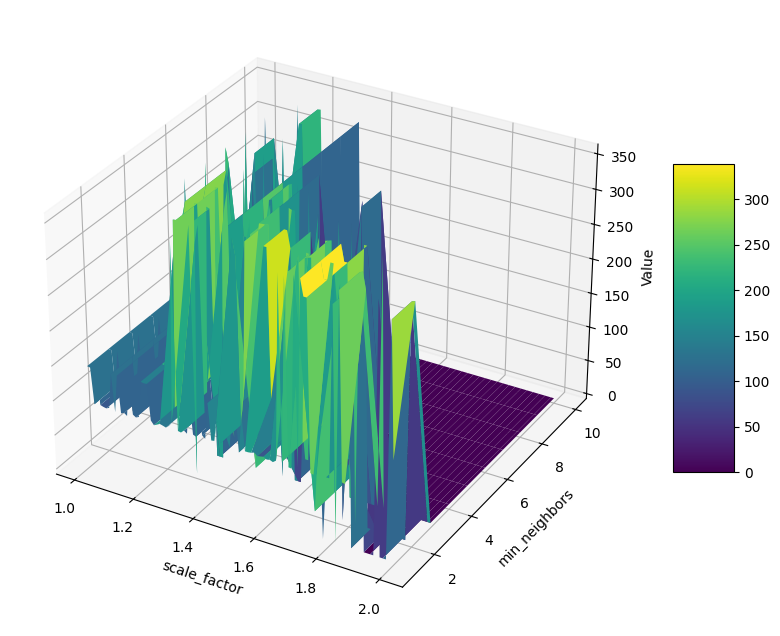

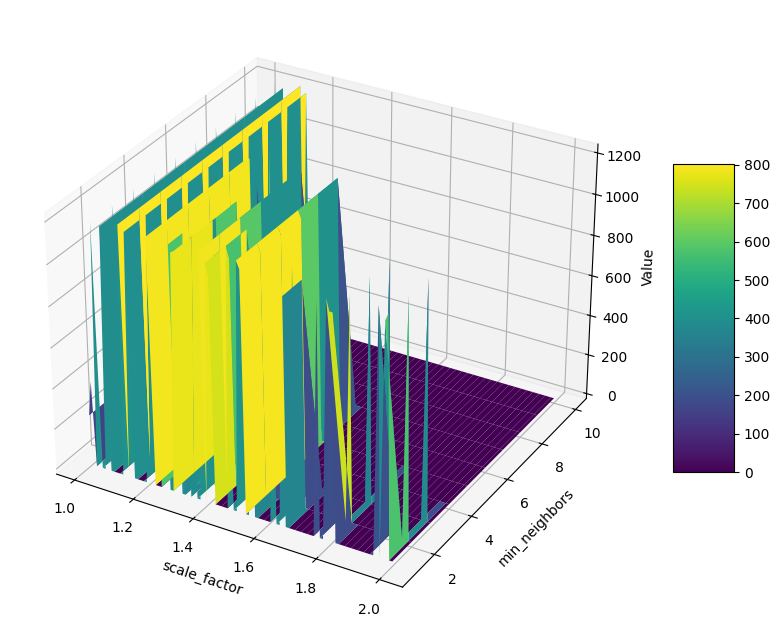

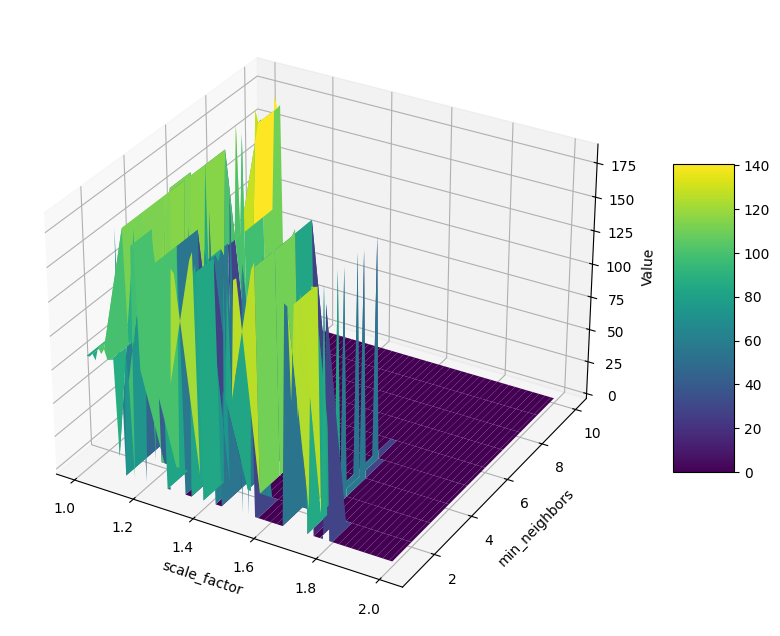

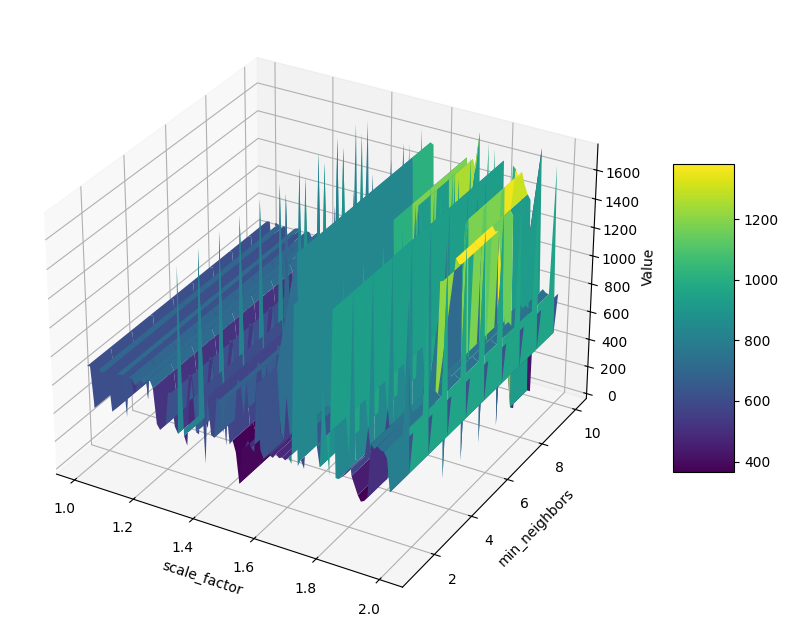

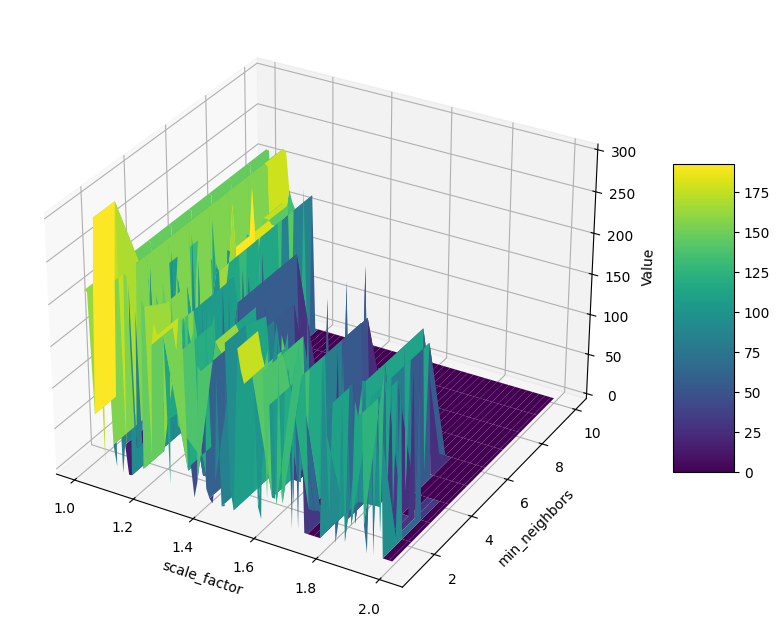

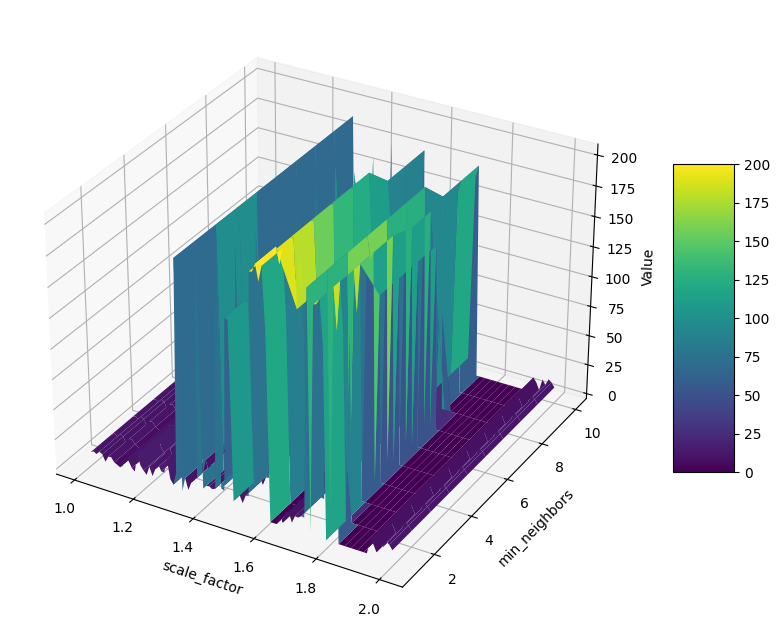

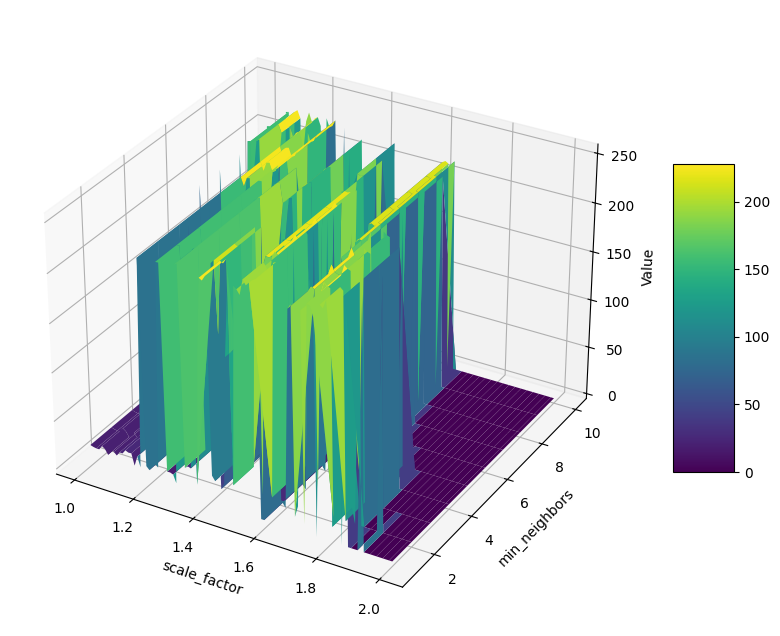

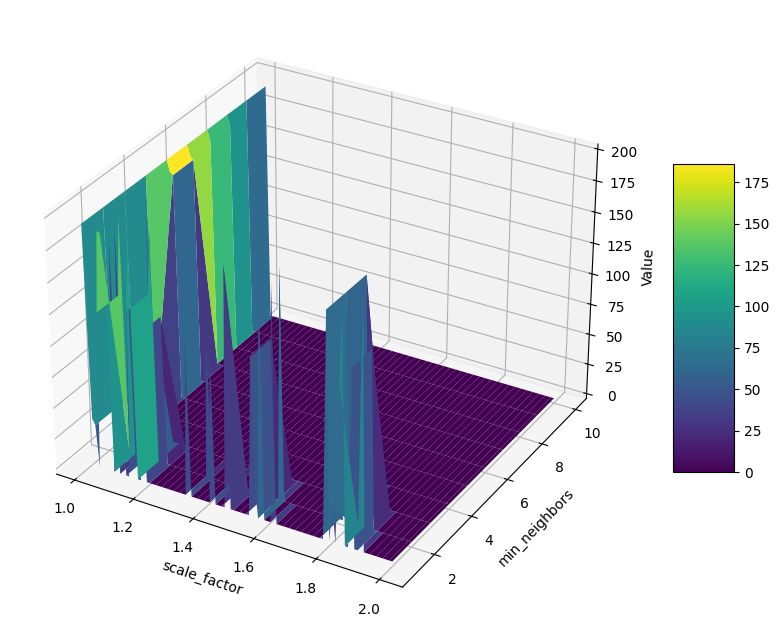

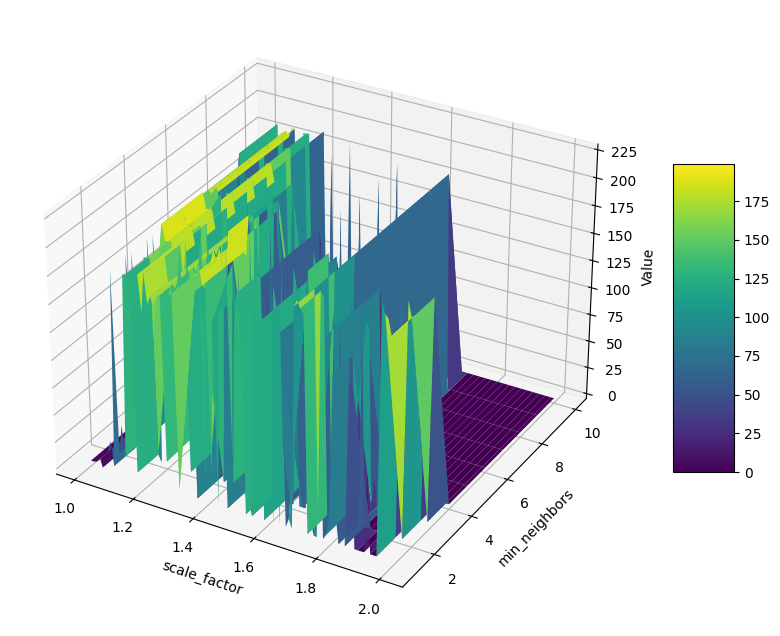

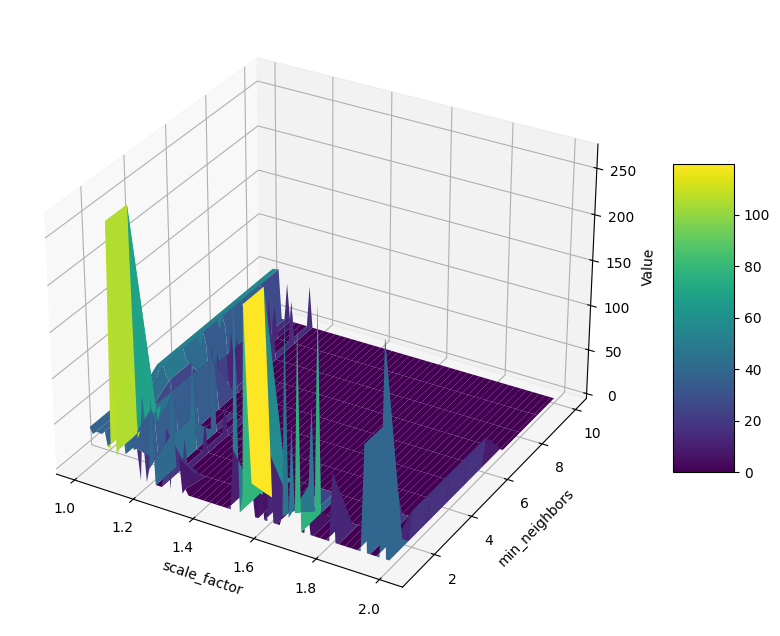

In [333]:
for i in range(10):
    map_data(i)

# Part 5

Create a function to return the average of all the row/column combinations containing the smallest numbers, non zero.

In [382]:
def find_best(num):
    rows = 0
    cols = 0

    df = pd.read_csv(f"eye_table_{num}.csv", index_col = 0)  
    df_no_zeros = df.replace(0, pd.NA)
    min_value = df_no_zeros.min().min()
    min_positions = list(df_no_zeros.stack().loc[lambda x: x == min_value].index)

    for i in min_positions:
        f1 = float(i[0])
        f2 = float(i[1])
        rows += f1
        cols += f2

    row_top = rows / len(min_positions)
    col_top = cols / len(min_positions)

    return(row_top, col_top)

Create a function to calculate the average of the best neighbor/scale factor numbers from all images

In [383]:
def average_best():
    min_neighbor_list = []
    min_scale_factor_list = []
    neighbor = 0
    scale = 0.0
    min_neighbor_average = 0
    min_scale_factor_average = 0.0

    for i in range(10):
        n, s = find_best(i)
        min_neighbor_list.append(n)
        min_scale_factor_list.append(s)

    for a in min_neighbor_list:
        neighbor += a

    for b in min_scale_factor_list:
        scale += b

    min_neighbor_average = neighbor / len(min_neighbor_list)
    min_scale_factor_average = scale / len(min_scale_factor_list)

    return(min_neighbor_average, min_scale_factor_average)

Run function to store best neighbor and scale factor

In [ ]:
best_neighbor, best_scale = average_best()

Output best neighbor and scale factor numbers

In [385]:
print(best_neighbor)
print(best_scale)

1.8
1.4405000000000001


# Part 6

Alter functions to accomidate new numbers

In [400]:
def detect_eyes2(img, g_distances):
    eye_distances = []
    coordinate_distances = []

    eye_img = img.copy()
    height, width, channels = eye_img.shape
    eye_rect = eye_cascade.detectMultiScale(
        eye_img, 
        scaleFactor = 1.44, 
        minNeighbors = 2,
        minSize = (int(width * 1.5), int(height * 1.5))
        )

    for (x, y, w, h) in eye_rect:
        if (y + h / 2 < height * 0.5):
            eye_distances.append(x)
            eye_distances.append(y)
            # Blue Box
            cv2.rectangle(eye_img, (x, y), (x + w, y + h), (255, 0, 0), 1)
        
    if len(eye_distances) < 2:
        eye_distances.append(10)
        eye_distances.append(10)      
        eye_distances.append(10)
        eye_distances.append(10) 

    if len(eye_distances) < 4:
        eye_distances.append(10)
        eye_distances.append(10)      
        eye_distances.append(10)
        eye_distances.append(10) 


    glx, gly, grx, gry = g_distances             
    lx, ly, rx, ry = eye_distances 
    measured = measure_distance(lx, ly, glx, gly, rx, ry, grx, gry)
    py_measured = float(measured)
    round_measured = round(py_measured, 2)
    coordinate_distances.append(round_measured)

    return coordinate_distances

Run function to calculate differences between the results of the new numbers and the true center fr each image.

In [ ]:
eye_images_copy2 = img_list.copy()
box_coords2 = []
boxes2 = []

for i in range(len(img_list)):
    boxes2 = detect_eyes2(eye_images_copy2[i], eye_coords[i])
    box_coords2.append(boxes2)

Verify correct number of results

In [407]:
print(len(box_coords2))
print(len(box_coords2[0]))

10
1


View results to compare

In [404]:
print(box_coords2)

[[118.32], [113.27], [49.72], [183.9], [165.46], [134.55], [121.81], [124.41], [132.26], [179.45]]


# Part 7

Based on the data recieved during the final test, the distances are much more consitant accross all of the images. There is minimal variation as compared to the previous trial. Though some of the images were were much closer during the first run, some were off by enormous amounts. The lack of consistancy indicates poor accuracy. The significantly closer and more consistant values of the run after making the changes indicates that the changes performed utilizing data accumulated from averages to improve the accuracy was successful.